# About the dataset ( FER2013 )
This is **FER2013** dataset,
kaggle -> https://www.kaggle.com/datasets/msambare/fer2013

The data consists of 48x48 pixel grayscale images of faces. The faces have been automatically registered so that the face is more or less centred and occupies about the same amount of space in each image.

The task is to categorize each face based on the emotion shown in the facial expression into one of seven categories (0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral). The training set consists of 28,709 examples and the public test set consists of 3,589 examples.

## Setting up the dataset
1. Setting up the kaggle directory
2. Downloading data from kaggle
3. Unzipping the data

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [ ]:
!kaggle datasets download -d msambare/fer2013

 70% 42.0M/60.3M [00:00<00:00, 144MB/s]
100% 60.3M/60.3M [00:00<00:00, 154MB/s]


In [ ]:
!unzip ./fer2013.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/train/sad/Training_65242339.jpg  
  inflating: data/train/sad/Training_65267116.jpg  
  inflating: data/train/sad/Training_65275626.jpg  
  inflating: data/train/sad/Training_6529266.jpg  
  inflating: data/train/sad/Training_65329617.jpg  
  inflating: data/train/sad/Training_65338712.jpg  
  inflating: data/train/sad/Training_65338797.jpg  
  inflating: data/train/sad/Training_65387162.jpg  
  inflating: data/train/sad/Training_65404494.jpg  
  inflating: data/train/sad/Training_65426218.jpg  
  inflating: data/train/sad/Training_65430136.jpg  
  inflating: data/train/sad/Training_65437377.jpg  
  inflating: data/train/sad/Training_6545735.jpg  
  inflating: data/train/sad/Training_65463385.jpg  
  inflating: data/train/sad/Training_65473985.jpg  
  inflating: data/train/sad/Training_65502829.jpg  
  inflating: data/train/sad/Training_65505359.jpg  
  inflating: data/train/sad/Training_65508578.jpg  
  inflating: da

In [ ]:
!pip3 install opencv-python tensorflow keras

# Importing the Necessary libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns

import os
import random
import imghdr
import cv2

from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix,classification_report

from tensorflow.keras import Sequential,regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten,Dense,Conv2D,Activation,BatchNormalization,MaxPooling2D,Dropout
from tensorflow.keras.callbacks import ModelCheckpoint,CSVLogger,EarlyStopping,ReduceLROnPlateau

# Data Cleaning

In [ ]:
img_exts = ['jpeg','png','jpg']
data_dir = './data/train'
for root,dirs,files in os.walk(data_dir):
  for file in files:
    file_path = os.path.join(root,file)
    try:
      file_type = imghdr.what(file_path)
      if file_type not in img_exts:
        print(f'Image not in ext list {file_path}')
        os.remove(file_path)
      else:
        img = cv2.imread(file_path)
    except Exception as e:
        print(f'Issue with file {file_path}. Error: {e}')
        os.remove(file_path)

# Data Analysis

In [ ]:
def count_images_subdir(dir,name):
  counts = {}
  for items in os.listdir(dir):
    i_dir = os.path.join(dir,items)
    if os.path.isdir(i_dir):
      counts[items] = len(os.listdir(i_dir))
  df = pd.DataFrame(counts,index=[name])
  return df
test_counts = count_images_subdir('./data/test','test')
train_counts = count_images_subdir('./data/train','train')
print(test_counts,'\n\n',train_counts)

      surprise  disgust  neutral   sad  happy  fear  angry
test       831      111     1233  1247   1774  1024    958 

        surprise  disgust  neutral   sad  happy  fear  angry
train      3171      436     4965  4830   7215  4097   3995


<Axes: >

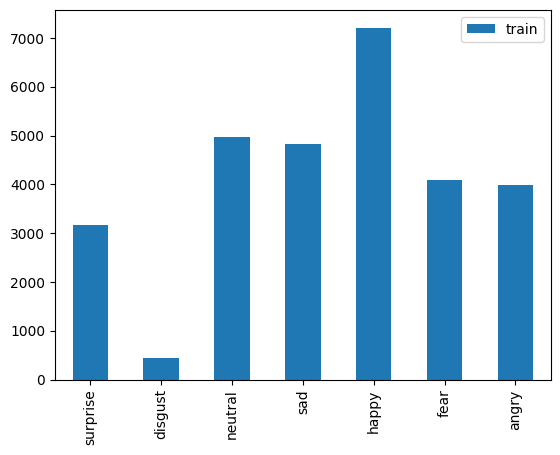

In [ ]:
train_counts.transpose().plot(kind='bar')

<Axes: >

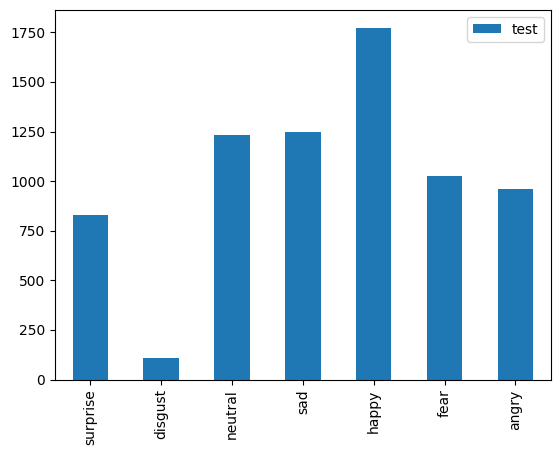

In [ ]:
test_counts.transpose().plot(kind='bar')

# Removing folders of disgust and surprise emotion, since we are only using Sad, Happy, Neutral, Angry and Fear for music recommendation after Emotion Detection.

In [ ]:
import shutil
remove_folders = ['disgust','surprise']
train_path = './data/train'
test_path = './data/test'
for folder in remove_folders:
  rm_train_path = os.path.join(train_path,folder)
  rm_test_path = os.path.join(test_path,folder)
  shutil.rmtree(rm_train_path)
  shutil.rmtree(rm_test_path)

# Plotting one for each emotion

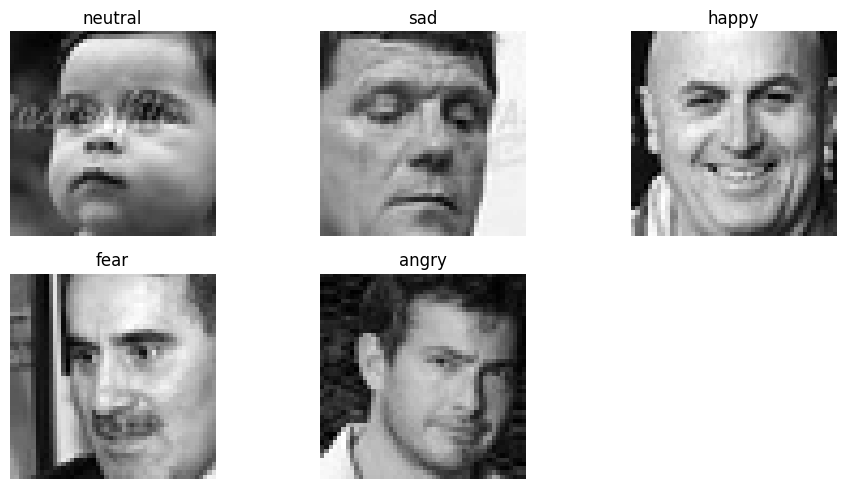

In [ ]:
emotions = os.listdir('./data/train/')
plt.figure(figsize = (10,5))
random.seed(42)
for i,emotion in list(enumerate(emotions,1)):
  folder = os.path.join('./data/train',emotion)
  img_path = os.path.join(folder,random.choice(os.listdir(folder)))
  img = plt.imread(img_path)
  plt.subplot(2,3,i)
  plt.imshow(img,cmap='gray')
  plt.title(emotion)
  plt.axis('off')
  plt.tight_layout()

# Checking Shapes and Channels

In [ ]:
image = os.path.join('./data/train/angry',random.choice(os.listdir('./data/train/angry')))
img = cv2.imread(image,cv2.IMREAD_GRAYSCALE)
# print(img)
if img is not None:
  print(f'shape of image: {img.shape}')
else:
  print("Image could not be loaded")

shape of image: (48, 48)


# Creating Directories to contain data of models

In [ ]:
os.makedirs('./Emotion_Detection_FER',exist_ok = True)

model_names = [
    'Custom_CNN',
    'ResNet'
]
for model in model_names:
  os.makedirs(os.path.join('./Emotion_Detection_FER',model),exist_ok=True)

print(f'Project directory structure created ')


Project directory structure created 


# Model 1 : Custom CNN

In [ ]:
train_dir = './data/train'
test_dir = './data/test'

In [ ]:
# Setting up some of the params
img_w,img_h = 48,48
batch_size = 64
epochs = 100
nums_classes = 5

## Setting up data generators

In [ ]:
data_generator = ImageDataGenerator(rescale = 1./255,
                                validation_split=0.2)
train_generator = data_generator.flow_from_directory(train_dir,
                                                     target_size = (img_w,img_h),
                                                     color_mode = 'grayscale',
                                                     class_mode = 'categorical',
                                                     batch_size = batch_size,
                                                     subset = 'training')
test_generator = data_generator.flow_from_directory(test_dir,
                                                     target_size = (img_w,img_h),
                                                     color_mode = 'grayscale',
                                                     class_mode = 'categorical',
                                                     batch_size = batch_size,)
validation_generator = data_generator.flow_from_directory(train_dir,
                                                     target_size = (img_w,img_h),
                                                     color_mode = 'grayscale',
                                                     class_mode = 'categorical',
                                                     batch_size = batch_size,
                                                     subset = 'validation')


Found 20082 images belonging to 5 classes.
Found 6236 images belonging to 5 classes.
Found 5020 images belonging to 5 classes.


In [ ]:
train_class_labels = train_generator.class_indices
print(f'Train Class Labels : {train_class_labels}')
test_class_labels = test_generator.class_indices
print(f'Test Class Labels : {test_class_labels}')
validation_class_labels = validation_generator.class_indices
print(f'Validation Class Labels : {validation_class_labels}')

Train Class Labels : {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}
Test Class Labels : {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}
Validation Class Labels : {'angry': 0, 'fear': 1, 'happy': 2, 'neutral': 3, 'sad': 4}


## Creating the model

In [ ]:
# Initialising CNN
model = Sequential()

# Adding convolutional layers with activations
model.add(Conv2D(32,kernel_size=(3,3),padding='same',kernel_initializer="glorot_uniform",input_shape=(img_w, img_h, 1)))
model.add(Activation('relu'))
model.add(Conv2D(64,kernel_size=(3,3),padding='same'))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))

model.add(Conv2D(128, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(256, kernel_size=(3, 3), kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(Conv2D(512, kernel_size=(3, 3), padding='same', kernel_regularizer=regularizers.l2(0.01)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))
model.add(Dropout(0.5))

# Output layer
model.add(Dense(nums_classes))
model.add(Activation('softmax'))

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 activation (Activation)     (None, 48, 48, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        18496     
                                                                 
 activation_1 (Activation)   (None, 48, 48, 64)        0         
                                                                 
 batch_normalization (Batch  (None, 48, 48, 64)        256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 24, 24, 64)        0         
 D)                                                     

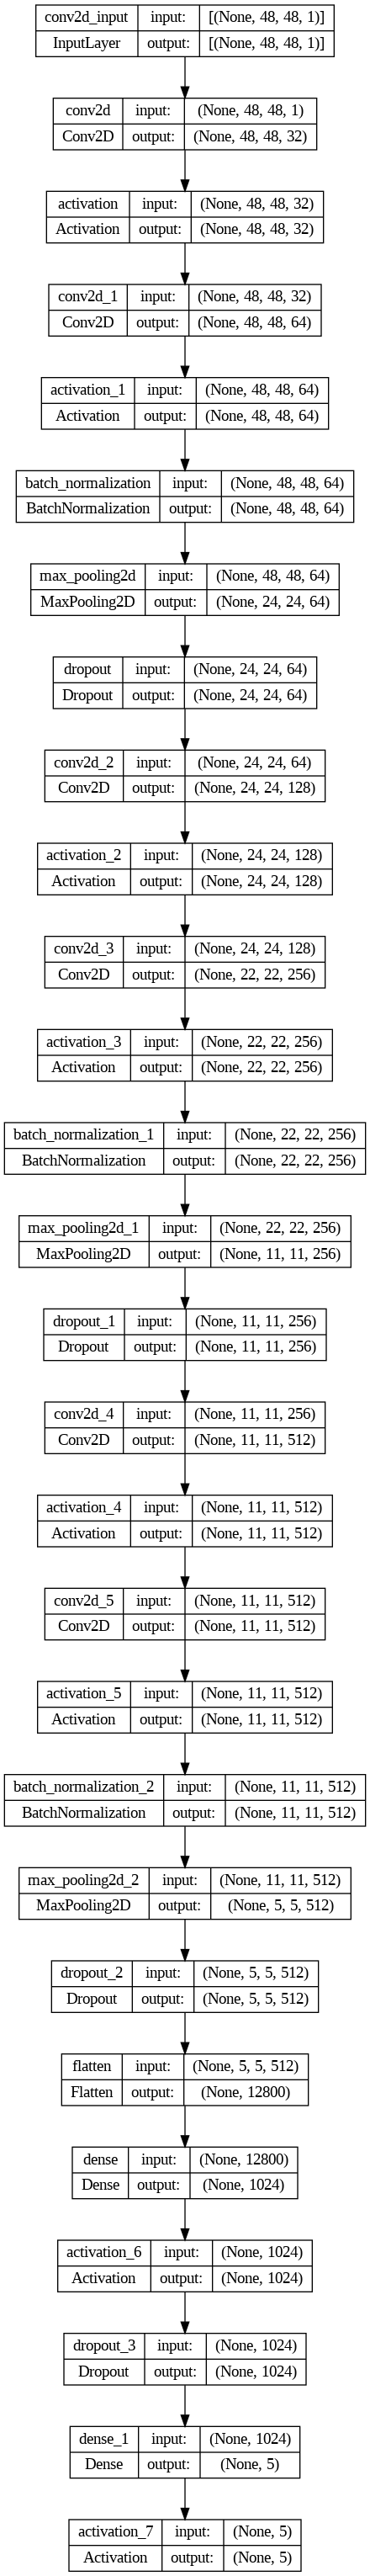

In [ ]:
plot_model(model, to_file = './Emotion_Detection_FER/Custom_CNN/Architecture.png',
           show_shapes=True, show_layer_names=True)

In [ ]:
cnn_path = './Emotion_Detection_FER/Custom_CNN/'
name = 'Custom_CNN_Basic_model.keras'
chk_path = os.path.join(cnn_path,name)
chk_path

'./Emotion_Detection_FER/Custom_CNN/Custom_CNN_Basic_model.keras'

# Setting Up Callbacks:
+ Checkpoint
+ Early Stopping
+ Reduce Learning Rate
+ CSV logger

In [ ]:
checkpoint = ModelCheckpoint(chk_path,
                             monitor='val_loss',
                             verbose=1,
                             save_best_only=True,
                             mode='min')
earlystop = EarlyStopping(monitor='val_loss',
                          verbose=1,
                          min_delta=0,
                          patience=3,
                          mode='min',
                          restore_best_weights=True,
                          start_from_epoch=10)
reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.2,
                              patience=5,
                              verbose=1,
                              min_delta=0.0001)
csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))
callbacks = [checkpoint, earlystop, reduce_lr, csv_logger]

In [ ]:
train_generator.samples

20082

## Fitting the model

In [ ]:
train_steps_per_epoch = train_generator.samples//train_generator.batch_size + 1
validation_steps_epoch = validation_generator.samples//validation_generator.batch_size + 1
test_steps_epoch = test_generator.samples//test_generator.batch_size + 1

In [ ]:
history = model.fit(
    train_generator,
    steps_per_epoch = train_steps_per_epoch,
    epochs = 50,
    verbose = 1,
    callbacks=callbacks,
    validation_data = validation_generator,
    validation_steps = validation_steps_epoch
)

Epoch 1/50
314/314 [==============================] - ETA: 0s - loss: 12.3746 - accuracy: 0.2892
Epoch 1: val_loss improved from inf to 12.79971, saving model to ./Emotion_Detection_FER/Custom_CNN/Custom_CNN_Basic_model.keras
314/314 [==============================] - 41s 82ms/step - loss: 12.3746 - accuracy: 0.2892 - val_loss: 12.7997 - val_accuracy: 0.1976 - lr: 1.0000e-04
Epoch 2/50
314/314 [==============================] - ETA: 0s - loss: 10.4544 - accuracy: 0.3581
Epoch 2: val_loss improved from 12.79971 to 10.07887, saving model to ./Emotion_Detection_FER/Custom_CNN/Custom_CNN_Basic_model.keras
314/314 [==============================] - 22s 70ms/step - loss: 10.4544 - accuracy: 0.3581 - val_loss: 10.0789 - val_accuracy: 0.4018 - lr: 1.0000e-04
Epoch 3/50
314/314 [==============================] - ETA: 0s - loss: 8.6502 - accuracy: 0.4050
Epoch 3: val_loss improved from 10.07887 to 8.09155, saving model to ./Emotion_Detection_FER/Custom_CNN/Custom_CNN_Basic_model.keras
314/314 [=

## Plotting and Analyzing the model results

In [ ]:
def plot_training_history(history):
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(len(accuracy))
  plt.figure(figsize=(10,5))

  plt.subplot(1, 2, 1)
  plt.title('Training and Validation Accuracy')
  plt.plot(epochs_range, accuracy, label='Training Accuracy')
  plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
  plt.legend()

  plt.subplot(1, 2, 2)
  plt.title('Training and Validation Loss')
  plt.plot(epochs_range, loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.legend()

  plt.show()

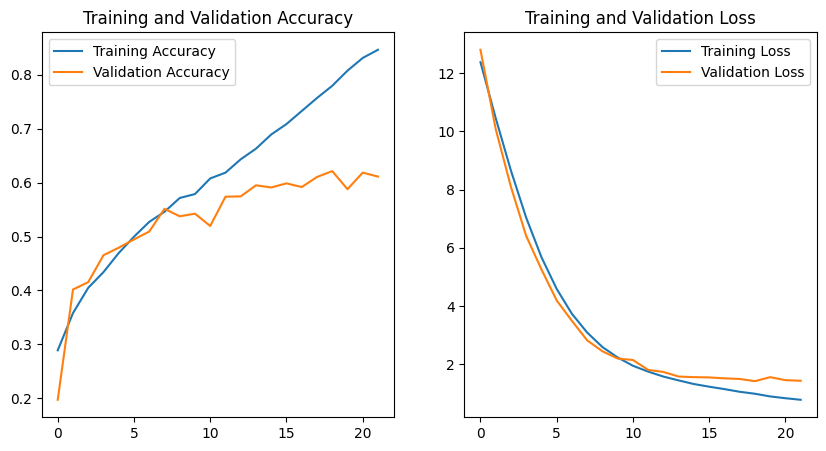

In [ ]:
plot_training_history(history)

## Model Evaluation

In [ ]:
test_loss, test_accuracy = model.evaluate(test_generator)
train_loss, train_accuracy = model.evaluate(train_generator)
print("final train accuracy = {:.2f} , Test accuracy = {:.2f}".format(train_accuracy*100, test_accuracy*100))

314/314 [==============================] - 8s 25ms/step - loss: 0.7703 - accuracy: 0.8946
final train accuracy = 89.46 , Test accuracy = 63.39


## Plotting Confusion Matrix

98/98 [==============================] - 2s 21ms/step


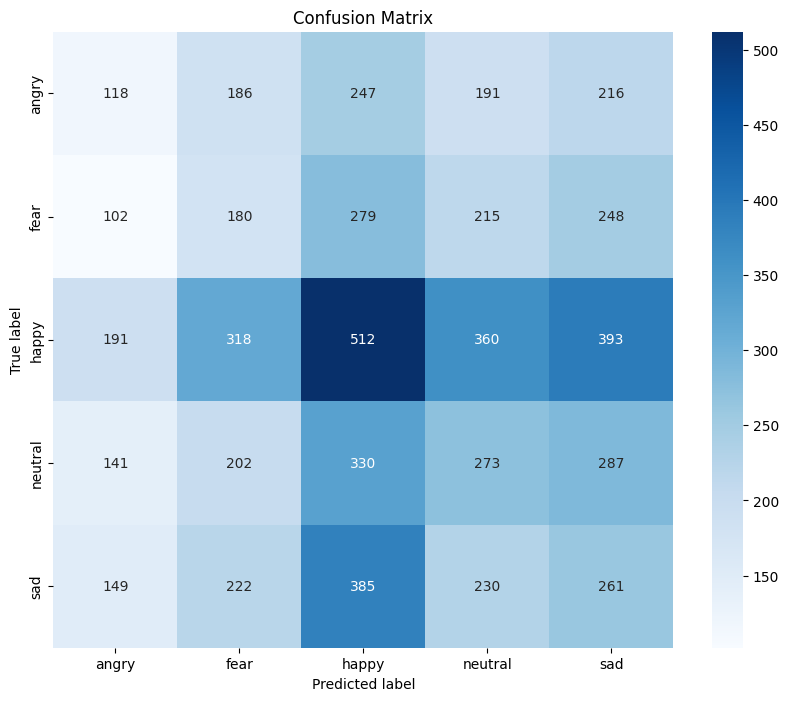

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

**NOTE**

Here, on seeing the confusion matrix, we can clearly say that our model is predicting most of the images as happy and thus getting a good score. But in real application it doesn't works out. Therefore, we will disregard our Model 1 and search for a better model.

## Printing Classification Services

In [ ]:
report = classification_report(true_classes,predicted_classes,target_names=class_labels)
print('Classification Report: ',report)

Classification Report:                precision    recall  f1-score   support

       angry       0.17      0.12      0.14       958
        fear       0.16      0.18      0.17      1024
       happy       0.29      0.29      0.29      1774
     neutral       0.22      0.22      0.22      1233
         sad       0.19      0.21      0.20      1247

    accuracy                           0.22      6236
   macro avg       0.20      0.20      0.20      6236
weighted avg       0.22      0.22      0.21      6236



## Making Predictions

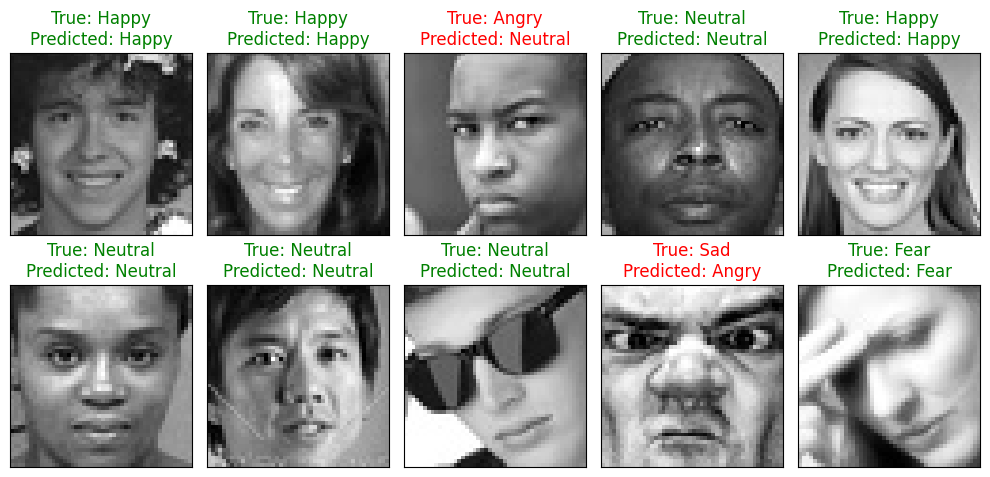

In [ ]:
Emotion_Classes = ['Angry', 'Fear', 'Happy', 'Neutral', 'Sad']
batch_size = test_generator.batch_size
Random_batch = np.random.randint(0, len(test_generator) - 1) # selecting random batch from test generator
Random_Img_Index = np.random.randint(0, batch_size, 10) # random image indices from the batch
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(10, 5),
                         subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]], axis=0)

    Model_Prediction = np.argmax(model.predict(tf.expand_dims(Random_Img, axis=0), verbose=0), axis=1)[0]

    ax.imshow(Random_Img.squeeze(), cmap='gray')  # Assuming the images are grayscale
    # Setting the title with true and predicted labels, colored based on correctness
    color = "green" if Emotion_Classes[Random_Img_Label] == Emotion_Classes[Model_Prediction] else "red"
    ax.set_title(f"True: {Emotion_Classes[Random_Img_Label]}\nPredicted: {Emotion_Classes[Model_Prediction]}", color=color)

plt.tight_layout()
plt.show()

In [ ]:
model.save('./Emotion_Detection_FER/Custom_CNN/Final_CNN_Model.keras')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
model.save('./drive/MyDrive/Final_CNN_Model.keras')


# Model 2 : Transfer Learning - ResNet50
**with Image Augmentation**

In [ ]:
train_dir = './data/train'
test_dir = './data/test'

batch_size = 64

# Data Augmentatiohn configuration for training data
train_datagen = ImageDataGenerator(
                                  rescale=1/255.
                                 )

test_datagen = ImageDataGenerator(
    rescale=1/255.
)

train_generator = train_datagen.flow_from_directory(
                                                    train_dir,
                                                    class_mode="categorical",
                                                    target_size=(224, 224),
                                                    color_mode='rgb',
                                                    shuffle=True,
                                                    batch_size=batch_size,
                                                    subset='training'
                                                   )

test_generator = test_datagen.flow_from_directory(
                                                  test_dir,
                                                  class_mode="categorical",
                                                  target_size=(224, 224),
                                                  color_mode="rgb",
                                                  shuffle=False,
                                                  batch_size=batch_size
                                                 )


Found 25102 images belonging to 5 classes.
Found 6236 images belonging to 5 classes.


## Introducing Class Weights for Imbalanced

In [ ]:
from sklearn.utils.class_weight import compute_class_weight
classes = np.array(train_generator.classes)

class_weights = compute_class_weight(
    class_weight = 'balanced',
    classes = np.unique(classes),
    y=classes
)

class_weights_dict = dict(enumerate(class_weights))

print("Class Weights Dictionary:", class_weights_dict)

Class Weights Dictionary: {0: 1.2566708385481853, 1: 1.2253844276299732, 2: 0.6958281358281359, 3: 1.0111581067472306, 4: 1.0394202898550724}


In [ ]:
ResNet50V2 = tf.keras.applications.ResNet50V2(input_shape=(224, 224, 3),
                                               include_top= False,
                                               weights='imagenet'
                                               )

94668760/94668760 [==============================] - 1s 0us/step


In [ ]:
ResNet50V2.trainable = True
# freezing all layers except last 50
for layer in ResNet50V2.layers[:-50]:
    layer.trainable = False

In [ ]:
model = Sequential([
                  ResNet50V2,
                  Dropout(0.25),
                  BatchNormalization(),
                  Flatten(),
                  Dense(64, activation='relu'),
                  BatchNormalization(),
                  Dropout(0.5),
                  Dense(5,activation='softmax')
                ])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 7, 7, 2048)        23564800  
                                                                 
 dropout_6 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 batch_normalization_5 (Bat  (None, 7, 7, 2048)        8192      
 chNormalization)                                                
                                                                 
 flatten_2 (Flatten)         (None, 100352)            0         
                                                                 
 dense_4 (Dense)             (None, 64)                6422592   
                                                                 
 batch_normalization_6 (Bat  (None, 64)                256       
 chNormalization)                                     

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
resnet_path = '/content/Emotion_Detection_FER/ResNet'
name = 'ResNet50_Transfer_Learning.keras'
chk_path = os.path.join(resnet_path, name)

checkpoint = ModelCheckpoint(filepath=chk_path,
                             save_best_only=True,
                             verbose=1,
                             mode='min',
                             monitor='val_loss')

earlystop = EarlyStopping(monitor = 'val_accuracy',
                          patience = 5,
                          restore_best_weights = True,
                          verbose=1)

csv_logger = CSVLogger(os.path.join(cnn_path,'training.log'))

callbacks = [checkpoint, earlystop, csv_logger]

train_steps_per_epoch = train_generator.samples // train_generator.batch_size + 1
test_steps_epoch = test_generator.samples // test_generator.batch_size + 1

In [ ]:
train_history = model.fit(
                          train_generator,
                          steps_per_epoch=train_steps_per_epoch,
                          epochs=100,
                          validation_data=test_generator,
                          validation_steps=test_steps_epoch,
                          class_weight=class_weights_dict,
                          callbacks = callbacks
                         )

Epoch 1/100
393/393 [==============================] - ETA: 0s - loss: 1.2908 - accuracy: 0.5255
Epoch 1: val_loss improved from inf to 1.61190, saving model to /content/Emotion_Detection_FER/ResNet/ResNet50_Transfer_Learning.keras
393/393 [==============================] - 145s 334ms/step - loss: 1.2908 - accuracy: 0.5255 - val_loss: 1.6119 - val_accuracy: 0.5630
Epoch 2/100
393/393 [==============================] - ETA: 0s - loss: 1.0283 - accuracy: 0.6294
Epoch 2: val_loss improved from 1.61190 to 1.01470, saving model to /content/Emotion_Detection_FER/ResNet/ResNet50_Transfer_Learning.keras
393/393 [==============================] - 122s 309ms/step - loss: 1.0283 - accuracy: 0.6294 - val_loss: 1.0147 - val_accuracy: 0.6119
Epoch 3/100
393/393 [==============================] - ETA: 0s - loss: 0.9386 - accuracy: 0.6697
Epoch 3: val_loss did not improve from 1.01470
393/393 [==============================] - 120s 304ms/step - loss: 0.9386 - accuracy: 0.6697 - val_loss: 8.1591 - val_

# Plotting The Confusion Matrix

98/98 [==============================] - 21s 203ms/step


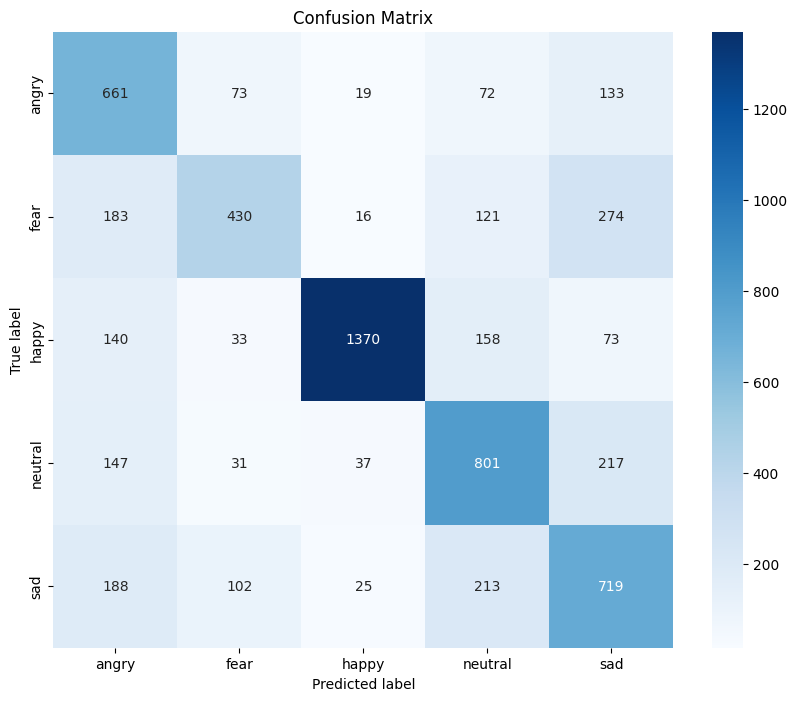

In [ ]:
true_classes = test_generator.classes
predicted_classes = np.argmax(model.predict(test_generator, steps=np.ceil(test_generator.samples/test_generator.batch_size)), axis=1)
class_labels = list(test_generator.class_indices.keys())

cm = confusion_matrix(true_classes, predicted_classes)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
model.save('/content/Emotion_Detection_FER/ResNet/Final_ResNet50_Model.keras')

In [ ]:
model.save('/content/drive/MyDrive/Final_ResNet50_Model.keras')

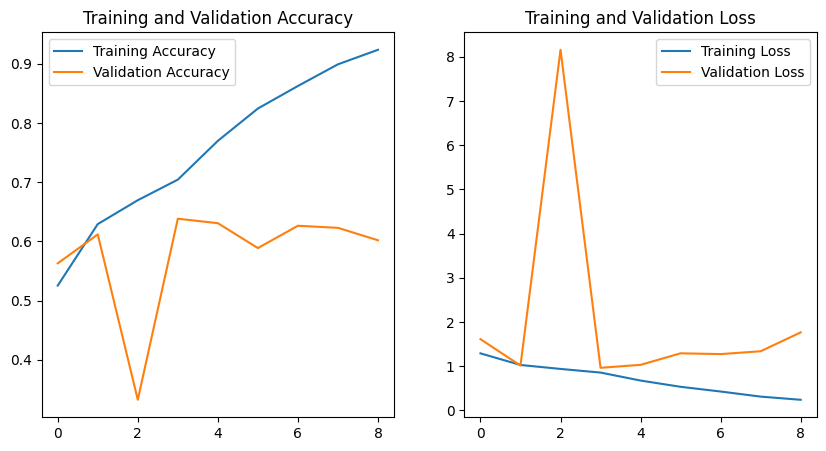

In [ ]:
plot_training_history(train_history)

In [ ]:
report = classification_report(true_classes,
                               predicted_classes,
                               target_names=class_labels)
print("Classification Report:\n", report)

Classification Report:
               precision    recall  f1-score   support

       angry       0.50      0.69      0.58       958
        fear       0.64      0.42      0.51      1024
       happy       0.93      0.77      0.85      1774
     neutral       0.59      0.65      0.62      1233
         sad       0.51      0.58      0.54      1247

    accuracy                           0.64      6236
   macro avg       0.63      0.62      0.62      6236
weighted avg       0.67      0.64      0.64      6236

